REF: "I went to the store"
HYP: "I go to store"

- SUBSTITUTION: "went" → "go" (wrong word)
- DELETION: "the" missing (model skipped a word)
- INSERTION: (none in this example)

WER = (S + D + I) / N = (1 + 1 + 0) / 5 = 0.4 (40% error)

Example 1: "I went to the store"
         → "I go to the shop"
         S=2, D=0, I=0, WER=0.4

Example 2: "I went to the store"  
         → "I to store"
         S=0, D=2, I=0, WER=0.4

Same WER, but is the meaning preservation the same?

4. WER Variations & Alternatives
Research and document: a) Weighted WER (WWER)
Can you assign different costs to different error types?
Example: Substitution = 1, Deletion = 0.5, Insertion = 0.5
b) Character Error Rate (CER)
Word-level vs character-level
When is CER more appropriate?
c) Match Error Rate (MER)
Doesn't count insertions in denominator
MER = (S + D) / N
d) Normalized WER
Accounting for different normalization strategies
5. Parameters in jiwer
Look at the jiwer documentation and explain:
What transformations are available?
RemovePunctuation() - does this hide real errors?
ToLowerCase() - is "Apple" vs "apple" really an error?
RemoveMultipleSpaces() - formatting vs content
6. Critical Analysis for Your AMIA Report
Questions to explore:
For degraded VHP audio, which error types dominate? (S, D, or I?)
Does this tell you something about the failure mode?
High deletions = model gave up on unclear audio?
High substitutions = model heard something but got it wrong?

In [ ]:
# this notebook is created to learn about evaluating stt results.
# there are some inferences run on wandb, with evals being done which can be further explored here.

In [1]:
experiment_id = "vhp-pre2010-distil-large-v3-full-gpu"

In [2]:
import pandas as pd
df_inf = pd.read_parquet(f"../outputs/{experiment_id}/inference_results.parquet")
df_inf.head()

,file_id,collection_number,blob_path,hypothesis,duration_sec,processing_time_sec,language,status,error_message
0,0,AFC/2001/001/44003,loc_vhp/0/video.mp4,"Okay, today is October 29th, 2004. We're with ...",1986.815437,32.305685,en,success,None
1,1,AFC/2001/001/51925,loc_vhp/1/audio.mp3,I'm speaking with John Aaron Jr. John Aaron Jr...,618.144000,10.379629,en,success,None
2,2,AFC/2001/001/32482,loc_vhp/2/video.mp4,First thing I'm going to ask is your name. Alo...,2880.365750,52.445759,en,success,None
3,3,AFC/2001/001/41825,loc_vhp/3/audio.mp3,"In 2012, 2005, I am Brent Wains, and I'm inter...",1023.024000,17.514904,en,success,None
4,4,AFC/2001/001/18519,loc_vhp/4/audio.mp3,,0.000000,0.000000,,failed: FileNotFoundError,None of the candidate paths exist: ['loc_vhp/4...


In [3]:
df_eval = pd.read_csv(f"../outputs/{experiment_id}/evaluation_results.csv")
df_eval.head()

,file_id,collection_number,wer,substitutions,deletions,insertions,duration_sec,processing_time_sec,status
0,0,AFC/2001/001/44003,0.111906,163.0,234.0,41.0,1986.815437,32.305685,success
1,1,AFC/2001/001/51925,0.147541,60.0,58.0,17.0,618.144000,10.379629,success
2,2,AFC/2001/001/32482,0.051098,148.0,115.0,72.0,2880.365750,52.445759,success
3,3,AFC/2001/001/41825,0.121491,132.0,85.0,34.0,1023.024000,17.514904,success
4,4,AFC/2001/001/18519,NaN,NaN,NaN,NaN,0.000000,0.000000,failed: FileNotFoundError


In [ ]:
# all scripts for the experiments are put under /scripts.
# the evaluations bits are under evaluate.py
# here we are explaining step by step of how we compare the inference results (hypothesis) against gt (df_gt in the code):
# (assume args.parque is "../data/veterans_history_project_resources.parquet")

In [5]:
import pandas as pd
from bs4 import BeautifulSoup
import re

df_gt = pd.read_parquet("../data/raw/loc/veterans_history_project_resources_pre2010.parquet")

# Pick one example to walk through (file_id=0)
file_id = 0
gt_row = df_gt.iloc[file_id]

print(f"=== GROUND TRUTH FOR FILE {file_id} ===")
print(f"Collection: {gt_row['collection_number']}")
print()
print(f"Raw XML transcript (first 500 chars):")
print(gt_row['fulltext_file_str'][:500])

=== GROUND TRUTH FOR FILE 0 ===
Collection: AFC/2001/001/44003

Raw XML transcript (first 500 chars):
<?xml version="1.0" encoding="UTF-8"?>
<!DOCTYPE TEI.2
  PUBLIC "-//TEI//DTD TEI Lite XML ver. 1//EN" "http://lcweb2.loc.gov/natlib/schemas/teixlite.dtd">
<TEI.2>
   <teiHeader>
      <fileDesc>
         <titleStmt>
            <title>Interview with Thorvald Aanden, 10/29/2004</title>
            <author>Carole Larson and Christine Champeau [transcriber]</author>
            <respStmt>
               <resp>Encoded by</resp>
               <name>Matthew McCrady</name>
            </respStmt>
    


In [ ]:
# Show the cleaning process step-by-step
def clean_raw_transcript_str(fulltext_file_str: str) -> str:
    """
    Clean raw XML transcript from VHP dataset.
    This function is from scripts/evaluate.py
    """
    if not fulltext_file_str or pd.isna(fulltext_file_str):
        return ""
    
    l_transcript_lines = []
    
    # Step 1: Parse XML to extract speaker and text
    soup = BeautifulSoup(fulltext_file_str, 'xml')
    
    for sp in soup.find_all('sp'):
        try:
            speaker = sp.find('speaker').get_text(strip=True)
        except:
            speaker = "speaker_unknown"
        try:
            spoken_text = sp.find('p').get_text(strip=True)
        except:
            spoken_text = ""
        
        l_transcript_lines.append(f"<{speaker}>{spoken_text}</{speaker}> ")
    
    # Step 2: Merge lines
    transcript_lines = ''.join(l_transcript_lines)
    print("STEP 1 - After parsing XML:")
    print(transcript_lines[:300])
    print()
    
    # Step 3: Remove annotations: (), [], {}
    transcript_lines_stripped = re.sub(r'\([^)]*\)', '', transcript_lines)
    transcript_lines_stripped = re.sub(r'\[[^]]*\]', '', transcript_lines_stripped)
    transcript_lines_stripped = re.sub(r'\{[^}]*\)\}', '', transcript_lines_stripped)
    print("STEP 2 - After removing annotations:")
    print(transcript_lines_stripped[:300])
    print()
    
    # Step 4: Remove dashes and ellipsis
    transcript_lines_stripped = re.sub(r'--+', '', transcript_lines_stripped)
    transcript_lines_stripped = re.sub(r'\.{2,}', '', transcript_lines_stripped)
    
    # Step 5: Clean whitespace
    transcript_lines_stripped = re.sub(r'\s+', ' ', transcript_lines_stripped).strip()
    
    # Step 6: Remove speaker tags
    transcript_lines_stripped = re.sub(r'\<[^>]*\>', '', transcript_lines_stripped)
    print("STEP 3 - After removing speaker tags:")
    print(transcript_lines_stripped[:300])
    print()
    
    return transcript_lines_stripped

# Apply cleaning
reference = clean_raw_transcript_str(gt_row['fulltext_file_str'])
print("=== FINAL CLEANED REFERENCE ===")
print(f"Length: {len(reference)} characters")
print(f"First 500 chars: {reference[:500]}")

STEP 1 - After parsing XML:
<Carole Larson>Okay. Today is October 29th, 2004. We're with Thorvald Aanden from Fertile. Where were you born and raised?</Carole Larson> <Thorvald Aanden>Oh, I was born in South Dakota.</Thorvald Aanden> <Carole Larson>And you were raised there too?</Carole Larson> <Thorvald Aanden>Pardon? No, no.

STEP 2 - After removing annotations:
<Carole Larson>Okay. Today is October 29th, 2004. We're with Thorvald Aanden from Fertile. Where were you born and raised?</Carole Larson> <Thorvald Aanden>Oh, I was born in South Dakota.</Thorvald Aanden> <Carole Larson>And you were raised there too?</Carole Larson> <Thorvald Aanden>Pardon? No, no.

STEP 3 - After removing speaker tags:
Okay. Today is October 29th, 2004. We're with Thorvald Aanden from Fertile. Where were you born and raised? Oh, I was born in South Dakota. And you were raised there too? Pardon? No, no. You grew up there? No. I my folks moved back to to Underwood. We I had to work. Okay. And what were your p

In [ ]:
# Get hypothesis and show normalization
hypothesis = df_inf.iloc[file_id]['hypothesis']

print("=== HYPOTHESIS (Model Output) ===")
print(f"Length: {len(hypothesis)} characters")
print(f"First 500 chars: {hypothesis[:500]}")

=== HYPOTHESIS (Model Output) ===
Length: 19260 characters
First 500 chars: Okay, today is October 29th, 2004. We're with Thorvald Andon from Furtle. Where were you born and raised? Oh, I was born in South Dakota. And you were raised there too? Pardon? No. You grew up there? No, I, the folks moved back to, uh, go to Underwood. My head don't work. Okay. And what were your parents' names? Henry and Tilly And did you have brothers and sisters? Yeah, I had eight of them. Wow. I was the oldest. Oh, okay. And what, uh, three of them are already dead. Okay. Do you remember Pea


In [13]:
# Show normalization process
import jiwer

def normalize(s):
    """Normalize text for WER calculation (from scripts/evaluate.py)"""
    tx = jiwer.Compose([
        jiwer.ToLowerCase(),
        jiwer.RemovePunctuation(),
        jiwer.Strip(),
        jiwer.RemoveMultipleSpaces()
    ])
    return tx(s)

# Normalize both gt and predictions (gt was cleaned already in production setting)
ref_norm = normalize(reference)
hyp_norm = normalize(hypothesis)

print("=== NORMALIZATION PROCESS ===")
print()
print("REFERENCE BEFORE:")
print(reference[:200])
print()
print("REFERENCE AFTER:")
print(ref_norm[:200])
print()
print("HYPOTHESIS BEFORE:")
print(hypothesis[:200])
print()
print("HYPOTHESIS AFTER:")
print(hyp_norm[:200])
print()

=== NORMALIZATION PROCESS ===

REFERENCE BEFORE:
Okay. Today is October 29th, 2004. We're with Thorvald Aanden from Fertile. Where were you born and raised? Oh, I was born in South Dakota. And you were raised there too? Pardon? No, no. You grew up t

REFERENCE AFTER:
okay today is october 29th 2004 were with thorvald aanden from fertile where were you born and raised oh i was born in south dakota and you were raised there too pardon no no you grew up there no i my

HYPOTHESIS BEFORE:
Okay, today is October 29th, 2004. We're with Thorvald Andon from Furtle. Where were you born and raised? Oh, I was born in South Dakota. And you were raised there too? Pardon? No. You grew up there? 

HYPOTHESIS AFTER:
okay today is october 29th 2004 were with thorvald andon from furtle where were you born and raised oh i was born in south dakota and you were raised there too pardon no you grew up there no i the fol



In [ ]:
# Calculate WER step-by-step
m = jiwer.process_words(ref_norm, hyp_norm)

print("=== WER CALCULATION WITH jiwer(from scripts/evaluate.py)===")
print()
print(f"Reference words: {len(ref_norm.split())}")
print(f"Hypothesis words: {len(hyp_norm.split())}")
print()
print(f"Substitutions: {m.substitutions} (wrong word)")
print(f"Deletions: {m.deletions} (model missed word)")
print(f"Insertions: {m.insertions} (model added extra word)")
print()
print(f"Total errors: {m.substitutions + m.deletions + m.insertions}")
print(f"WER = Total errors / Reference words")
print(f"WER = {m.substitutions + m.deletions + m.insertions} / {len(ref_norm.split())}")
print(f"WER = {m.wer:.3f} ({m.wer*100:.1f}%)")
print()
print("Interpretation:")
if m.wer < 0.1:
    print("  → Excellent (< 10% error)")
elif m.wer < 0.3:
    print("  → Good (10-30% error)")
elif m.wer < 0.5:
    print("  → Fair (30-50% error)")
else:
    print("  → Poor (> 50% error)")

=== WER CALCULATION WITH jiwer===

Reference words: 3914
Hypothesis words: 3721

Substitutions: 163 (wrong word)
Deletions: 234 (model missed word)
Insertions: 41 (model added extra word)

Total errors: 438
WER = Total errors / Reference words
WER = 438 / 3914
WER = 0.112 (11.2%)

Interpretation:
  → Good (10-30% error)


In [16]:
# Visualize alignment on word-to-word level
alignment = jiwer.process_words(ref_norm, hyp_norm)

print("=== WORD ALIGNMENT (First 50 words) ===")
print()
ref_words = ref_norm.split()[:50]
hyp_words = hyp_norm.split()[:50]

# Simple alignment display
for i, (r, h) in enumerate(zip(ref_words, hyp_words)):
    if r == h:
        status = "✓"
    else:
        status = "✗ SUB"
    print(f"{i:3d}: REF='{r:15s}' HYP='{h:15s}' {status}")

=== WORD ALIGNMENT (First 50 words) ===

  0: REF='okay           ' HYP='okay           ' ✓
  1: REF='today          ' HYP='today          ' ✓
  2: REF='is             ' HYP='is             ' ✓
  3: REF='october        ' HYP='october        ' ✓
  4: REF='29th           ' HYP='29th           ' ✓
  5: REF='2004           ' HYP='2004           ' ✓
  6: REF='were           ' HYP='were           ' ✓
  7: REF='with           ' HYP='with           ' ✓
  8: REF='thorvald       ' HYP='thorvald       ' ✓
  9: REF='aanden         ' HYP='andon          ' ✗ SUB
 10: REF='from           ' HYP='from           ' ✓
 11: REF='fertile        ' HYP='furtle         ' ✗ SUB
 12: REF='where          ' HYP='where          ' ✓
 13: REF='were           ' HYP='were           ' ✓
 14: REF='you            ' HYP='you            ' ✓
 15: REF='born           ' HYP='born           ' ✓
 16: REF='and            ' HYP='and            ' ✓
 17: REF='raised         ' HYP='raised         ' ✓
 18: REF='oh             ' HYP='o

=== PROBLEM 1: All errors weighted equally ===

Example A: Meaning-preserving error
  REF: 'I am processing the data'
  HYP: 'I am procesing the data'
  → 1 substitution, WER = 0.2
  → BUT: Meaning unchanged (typo)

Example B: Meaning-changing error
  REF: 'I have a car'
  HYP: 'I have a scar'
  → 1 substitution, WER = 0.2
  → BUT: Meaning completely changed!

WER treats these the same!

=== PROBLEM 2: Contractions (from our data) ===
  REF: 'we're going'
  HYP: 'were going'
  → WER counts as 1 substitution
  → BUT: Almost identical meaning
  → Is this really an error?

=== PROBLEM 3: WER can exceed 100% ===
  When model hallucinates lots of insertions:
  REF: 'hello'
  HYP: 'hello my dear friend how are you today'
  → WER = (0 + 0 + 7) / 1 = 7.0 (700%!)
=== CHARACTER ERROR RATE (CER) ===

For languages like Mandarin/Japanese, or when typos matter:

REF: 'processing'
HYP: 'procesing'

WER: 1/1 = 1.0 (100% error)
CER: 1/10 = 0.1 (10% error)

Which better reflects the actual error severi

=== ERROR TYPE DISTRIBUTION (Your Data) ===

Substitutions: 46.1%
Deletions: 32.3%
Insertions: 21.6%



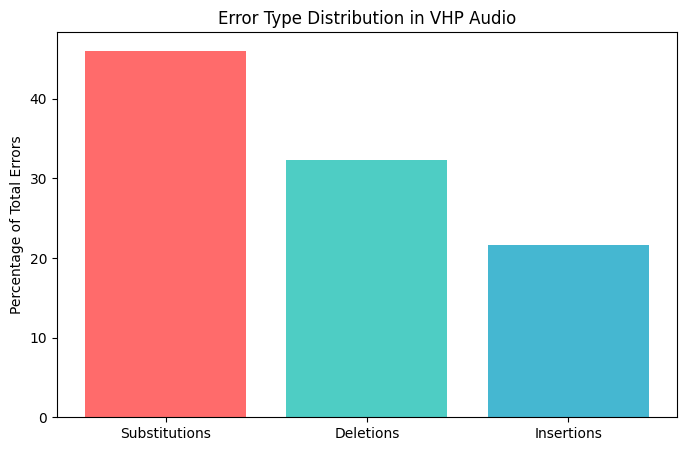

INTERPRETATION:


In [19]:
# Examples of WER's problems:

# Problem 1: Equal weighting
print("=== PROBLEM 1: All errors weighted equally ===")
print()
print("Example A: Meaning-preserving error")
print("  REF: 'I am processing the data'")
print("  HYP: 'I am procesing the data'")
print("  → 1 substitution, WER = 0.2")
print("  → BUT: Meaning unchanged (typo)")
print()
print("Example B: Meaning-changing error")  
print("  REF: 'I have a car'")
print("  HYP: 'I have a scar'")
print("  → 1 substitution, WER = 0.2")
print("  → BUT: Meaning completely changed!")
print()
print("WER treats these the same!")

# Problem 2: Contractions
print("\n=== PROBLEM 2: Contractions (from our data) ===")
print("  REF: 'we're going'")
print("  HYP: 'were going'")
print("  → WER counts as 1 substitution")
print("  → BUT: Almost identical meaning")
print("  → Is this really an error?")

# Problem 3: No upper bound
print("\n=== PROBLEM 3: WER can exceed 100% ===")
print("  When model hallucinates lots of insertions:")
print("  REF: 'hello'")
print("  HYP: 'hello my dear friend how are you today'")
print("  → WER = (0 + 0 + 7) / 1 = 7.0 (700%!)")

# Show CER calculation
print("=== CHARACTER ERROR RATE (CER) ===")
print()
print("For languages like Mandarin/Japanese, or when typos matter:")
print()
print("REF: 'processing'")
print("HYP: 'procesing'")
print()
print("WER: 1/1 = 1.0 (100% error)")
print("CER: 1/10 = 0.1 (10% error)")
print()
print("Which better reflects the actual error severity?")

# Show MER
print("\n=== MATCH ERROR RATE (MER) ===")
print("MER = (S + D) / N  (doesn't count insertions in denominator)")
print("Bounded between 0 and 1")
print()
print("Your file_id=0:")
print(f"  WER = {eval_row['wer']:.3f}")
print(f"  MER = ({eval_row['substitutions']} + {eval_row['deletions']}) / N")
print("  → Which is more interpretable?")

# What do the error types tell you?
import matplotlib.pyplot as plt

print("=== ERROR TYPE DISTRIBUTION (Your Data) ===")
print()

# Calculate proportions
total_errors = df_eval['substitutions'].sum() + df_eval['deletions'].sum() + df_eval['insertions'].sum()
sub_pct = df_eval['substitutions'].sum() / total_errors * 100
del_pct = df_eval['deletions'].sum() / total_errors * 100
ins_pct = df_eval['insertions'].sum() / total_errors * 100

print(f"Substitutions: {sub_pct:.1f}%")
print(f"Deletions: {del_pct:.1f}%")
print(f"Insertions: {ins_pct:.1f}%")
print()

# Plot
plt.figure(figsize=(8, 5))
plt.bar(['Substitutions', 'Deletions', 'Insertions'], 
        [sub_pct, del_pct, ins_pct],
        color=['#ff6b6b', '#4ecdc4', '#45b7d1'])
plt.ylabel('Percentage of Total Errors')
plt.title('Error Type Distribution in VHP Audio')
plt.show()

print("INTERPRETATION:")
if del_pct > 50:
    print("  → High deletions: Model gave up on unclear audio")
    print("  → Suggests: Audio quality issues (bandwidth-limited?)")
elif sub_pct > 50:
    print("  → High substitutions: Model heard something but got it wrong")
    print("  → Suggests: Acoustic confusion (similar sounding words)")
elif ins_pct > 30:
    print("  → High insertions: Model hallucinating extra content")
    print("  → Suggests: Model uncertainty or language model bias")